# Простейшая рекомендательная система

__Задача:__ добавить ранжирование товаров в блок "Смотрели ранее" небольшого интернет-магазина. В блоке надо показывать не последние просмотренные пользователем товары, а те товары из просмотренных, которые он наиболее вероятно купит. 

__Данные:__ выборки с пользовательскими сессиями - id просмотренных и id купленных товаров.

__Решение:__ для сравнения строятся 2 алгоритма, которые выбирают товары для рекомендаций на основе:

- ранжирования просмотренных пользователем товаров по частоте просмотров всеми пользователями магазина;

- ранжирования просмотренных пользователем товаров по частоте покупок всеми пользователями магазина.

__Внутренняя оценка качества для отбора алгоритма:__ 

$$Precision@k = \frac{КупленоИзРекомендованного}{КоличествоРекомендаций}$$
AveragePrecision@k — усреднённый по сессиям Precision@k

$$Recall@k = \frac{КупленоИзРекомендованного}{КоличествоКупленныхТоваров}$$
AverageRecall@k — усреднённый по сессиям Recall@k

__Рекомендуемая внешняя оценка качества решения:__ по количеству покупок в сравнении с прошлым решением в ходе А/В теста.

### загрузка библиотек

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### загрузка данных, разделенных на 2 выборки

In [89]:
df_train = pd.read_table('sessions_train.txt', header = None) # для обучения модели
df_train.head()

,0
0,"0,1,2,3,4,5;"
1,"9,10,11,9,11,12,9,11;"
2,"16,17,18,19,20,21;"
3,"24,25,26,27,24;"
4,"34,35,36,34,37,35,36,37,38,39,38,39;"


In [90]:
df_train.shape

(50000, 1)

In [91]:
df_test = pd.read_table('sessions_test.txt', header = None) # для контроля качества модели
df_test.head()

,0
0,"6,7,8;"
1,"13,14,15;"
2,"22,23;"
3,"28,29,30,31,32,33;"
4,"40,41;"


In [92]:
df_test.shape

(50000, 1)

### разделение id товаров на просмотренные и купленные и первичный анализ

In [93]:
df_train['viewed'] = df_train[0].apply(lambda s: s[0:s.find(';')].split(','))
df_train['bought'] = df_train[0].apply(lambda s: s[s.find(';')+1:].split(','))
df_train.drop(0, axis = 1, inplace = True)
df_train.head()

,viewed,bought
0,"[0, 1, 2, 3, 4, 5]",[]
1,"[9, 10, 11, 9, 11, 12, 9, 11]",[]
2,"[16, 17, 18, 19, 20, 21]",[]
3,"[24, 25, 26, 27, 24]",[]
4,"[34, 35, 36, 34, 37, 35, 36, 37, 38, 39, 38, 39]",[]


In [132]:
id_viewed_train = list(filter(lambda s: s != '', df_train['viewed'].aggregate(sum, axis = 0)))
id_bought_train = list(filter(lambda s: s != '', df_train['bought'].aggregate(sum, axis = 0)))
id_unique_train = set.union(set(id_viewed_train), set(id_bought_train))

In [141]:
print('--- Обучающая выборка ---')
print('Всего товаров: ', len(id_unique_train))
print('Просмотренных: ', len(set(id_viewed_train)))
print('Купленных: ', len(set(id_bought_train)))
print('Просмотренных и купленных: ', len(set(np.intersect1d(id_viewed_train, id_bought_train))))
print('Просмотренных, но не купленных: ', len(set(id_viewed_train)) - len(set(np.intersect1d(id_viewed_train, id_bought_train))))
print('Купленных, но не просмотренных: ', len(set(id_bought_train)) - len(set(np.intersect1d(id_viewed_train, id_bought_train))))

--- Обучающая выборка ---
Всего товаров:  77178
Просмотренных:  77064
Купленных:  4479
Просмотренных и купленных:  4365
Просмотренных, но не купленных:  72699
Купленных, но не просмотренных:  114


In [95]:
df_test['viewed'] = df_test[0].apply(lambda s: s[0:s.find(';')].split(','))
df_test['bought'] = df_test[0].apply(lambda s: s[s.find(';')+1:].split(','))
df_test.drop(0, axis = 1, inplace = True)
df_test.head()

,viewed,bought
0,"[6, 7, 8]",[]
1,"[13, 14, 15]",[]
2,"[22, 23]",[]
3,"[28, 29, 30, 31, 32, 33]",[]
4,"[40, 41]",[]


In [143]:
id_viewed_test = list(filter(lambda s: s != '', df_test['viewed'].aggregate(sum, axis = 0)))
id_bought_test = list(filter(lambda s: s != '', df_test['bought'].aggregate(sum, axis = 0)))
id_unique_test = set.union(set(id_viewed_test), set(id_bought_test))

In [144]:
print('--- Тестовая выборка ---')
print('Всего товаров: ', len(id_unique_test))
print('Просмотренных: ', len(set(id_viewed_test)))
print('Купленных: ', len(set(id_bought_test)))
print('Просмотренных и купленных: ', len(set(np.intersect1d(id_viewed_test, id_bought_test))))
print('Просмотренных, но не купленных: ', len(set(id_viewed_test)) - len(set(np.intersect1d(id_viewed_test, id_bought_test))))
print('Купленных, но не просмотренных: ', len(set(id_bought_test)) - len(set(np.intersect1d(id_viewed_test, id_bought_test))))

--- Тестовая выборка ---
Всего товаров:  76665
Просмотренных:  76518
Купленных:  4611
Просмотренных и купленных:  4464
Просмотренных, но не купленных:  72054
Купленных, но не просмотренных:  147


In [145]:
print('Товаров, которые есть в обеих выборках: ', len(id_unique_train ^ id_unique_test))
print('Товаров, которые есть только в обучающей выборке: ', len(id_unique_train) - len(id_unique_train ^ id_unique_test))
print('Товаров, которые есть только в тестовой выборке: ', len(id_unique_test) - len(id_unique_train ^ id_unique_test))

Товаров, которые есть в обеих выборках:  51777
Товаров, которые есть только в обучающей выборке:  25401
Товаров, которые есть только в тестовой выборке:  24888


### расчет частотности товаров обучающей выборки по просмотрам и покупкам

In [148]:
frequencies = pd.DataFrame(index = id_unique_train)
frequencies['viewed'] = frequencies.index.map(lambda i: id_viewed_train.count(i))
frequencies['bought'] = frequencies.index.map(lambda i: id_bought_train.count(i))
frequencies.head()

,viewed,bought
26569,2,0
49668,6,0
28481,2,0
65593,1,0
60307,5,1


### исключение из оценки сессий, в которых пользователь ничего не купил

In [149]:
df_train = df_train[df_train['bought'].apply(lambda s: s != [''])]
df_train.shape

(3608, 2)

In [150]:
df_train.head(10)

,viewed,bought
7,"[59, 60, 61, 62, 60, 63, 64, 65, 66, 61, 67, 6...","[67, 60, 63]"
10,"[84, 85, 86, 87, 88, 89, 84, 90, 91, 92, 93, 86]",[86]
19,"[138, 198, 199, 127]",[199]
30,"[303, 304, 305, 306, 307, 308, 309, 310, 311, ...",[303]
33,"[352, 353, 352]",[352]
55,[519],[519]
64,"[599, 600, 601, 602]","[603, 604, 602, 599, 605, 606, 600]"
72,"[687, 688, 689, 690, 691, 690, 688, 690, 688, ...","[690, 688]"
89,"[850, 851, 852]",[851]
93,"[879, 884, 170, 137, 170, 879, 884, 879, 885, ...",[879]


In [151]:
df_test = df_test[df_test['bought'].apply(lambda s: s != [''])]
df_test.shape

(3665, 2)

In [152]:
df_test.head()

,viewed,bought
7,"[63, 68, 69, 70, 66, 61, 59, 61, 66, 68]","[66, 63]"
14,"[158, 159, 160, 159, 161, 162]",[162]
19,"[200, 201, 202, 203, 204]","[201, 205]"
34,"[371, 372, 371]","[371, 373]"
40,[422],[422]


### сортировка просмотренных товаров по частотам в рамках одной сессии 

In [183]:
def sort_by_frequencies(x, freq):
    fr = [freq[i] if i in freq.index else 0 for i in x]
    return list(dict.fromkeys([k[0] for k in sorted(zip(x, fr), key = lambda i: i[1], reverse = True)]))

In [184]:
df_train['viewed_viewed'] = df_train['viewed'].apply(lambda x: sort_by_frequencies(x, frequencies['viewed']))
df_train['viewed_bought'] = df_train['viewed'].apply(lambda x: sort_by_frequencies(x, frequencies['bought']))
df_train.head()

,viewed,bought,viewed_viewed,viewed_bought
7,"[59, 60, 61, 62, 60, 63, 64, 65, 66, 61, 67, 6...","[67, 60, 63]","[63, 64, 60, 61, 65, 66, 67, 68, 59, 62]","[60, 63, 67, 59, 61, 62, 64, 65, 66, 68]"
10,"[84, 85, 86, 87, 88, 89, 84, 90, 91, 92, 93, 86]",[86],"[85, 93, 89, 90, 84, 92, 86, 87, 91, 88]","[86, 85, 93, 84, 87, 88, 89, 90, 91, 92]"
19,"[138, 198, 199, 127]",[199],"[127, 138, 198, 199]","[138, 199, 127, 198]"
30,"[303, 304, 305, 306, 307, 308, 309, 310, 311, ...",[303],"[303, 306, 304, 307, 309, 310, 305, 308, 311, ...","[303, 304, 305, 306, 307, 308, 309, 310, 311, ..."
33,"[352, 353, 352]",[352],"[352, 353]","[352, 353]"


In [185]:
df_test['viewed_viewed'] = df_test['viewed'].apply(lambda x: sort_by_frequencies(x, frequencies['viewed']))
df_test['viewed_bought'] = df_test['viewed'].apply(lambda x: sort_by_frequencies(x, frequencies['bought']))
df_test.head()

,viewed,bought,viewed_viewed,viewed_bought
7,"[63, 68, 69, 70, 66, 61, 59, 61, 66, 68]","[66, 63]","[63, 68, 66, 61, 59, 69, 70]","[63, 68, 69, 70, 66, 61, 59]"
14,"[158, 159, 160, 159, 161, 162]",[162],"[158, 162, 160, 159, 161]","[158, 162, 160, 159, 161]"
19,"[200, 201, 202, 203, 204]","[201, 205]","[204, 202, 203, 200, 201]","[204, 202, 200, 201, 203]"
34,"[371, 372, 371]","[371, 373]","[371, 372]","[371, 372]"
40,[422],[422],[422],[422]


### расчет метрик для оценки качества выдаваемых рекомендаций

In [190]:
def get_precision_array_for_sessions(k, recommended, bought):
    return len(np.intersect1d(recommended[:k], bought)) / float(k)

def get_recall_array_for_sessions(k, recommended, bought):
    return len(np.intersect1d(recommended[:k], bought)) / float(len(bought))

In [197]:
precision_train_viewed_k1 = df_train[['viewed_viewed', 'bought']] \
                                                .apply(lambda x: get_precision_array_for_sessions(1, x[0], x[1]), axis = 1)
precision_train_viewed_k5 = df_train[['viewed_viewed', 'bought']] \
                                                .apply(lambda x: get_precision_array_for_sessions(5, x[0], x[1]), axis = 1)

precision_train_bought_k1 = df_train[['viewed_bought', 'bought']] \
                                                .apply(lambda x: get_precision_array_for_sessions(1, x[0], x[1]), axis = 1)
precision_train_bought_k5 = df_train[['viewed_bought', 'bought']] \
                                                .apply(lambda x: get_precision_array_for_sessions(5, x[0], x[1]), axis = 1)

In [200]:
print('--- Метрика AveragePrecision@k для обучающей выборки ---')
print('При количестве рекомендаций k = 1 по частотности просмотров: ', precision_train_viewed_k1.mean())
print('При количестве рекомендаций k = 5 по частотности просмотров: ', precision_train_viewed_k5.mean())
print('При количестве рекомендаций k = 1 по частотности покупок: ', precision_train_bought_k1.mean())
print('При количестве рекомендаций k = 5 по частотности покупок: ', precision_train_bought_k5.mean())

--- Метрика AveragePrecision@k для обучающей выборки ---
При количестве рекомендаций k = 1 по частотности просмотров:  0.5121951219512195
При количестве рекомендаций k = 5 по частотности просмотров:  0.21252771618625918
При количестве рекомендаций k = 1 по частотности покупок:  0.8037694013303769
При количестве рекомендаций k = 5 по частотности покупок:  0.2525498891352649


In [201]:
precision_test_viewed_k1 = df_test[['viewed_viewed', 'bought']] \
                                                .apply(lambda x: get_precision_array_for_sessions(1, x[0], x[1]), axis = 1)
precision_test_viewed_k5 = df_test[['viewed_viewed', 'bought']] \
                                                .apply(lambda x: get_precision_array_for_sessions(5, x[0], x[1]), axis = 1)

precision_test_bought_k1 = df_test[['viewed_bought', 'bought']] \
                                                .apply(lambda x: get_precision_array_for_sessions(1, x[0], x[1]), axis = 1)
precision_test_bought_k5 = df_test[['viewed_bought', 'bought']] \
                                                .apply(lambda x: get_precision_array_for_sessions(5, x[0], x[1]), axis = 1)

In [202]:
print('--- Метрика AveragePrecision@k для тестовой выборки ---')
print('При количестве рекомендаций k = 1 по частотности просмотров: ', precision_test_viewed_k1.mean())
print('При количестве рекомендаций k = 5 по частотности просмотров: ', precision_test_viewed_k5.mean())
print('При количестве рекомендаций k = 1 по частотности покупок: ', precision_test_bought_k1.mean())
print('При количестве рекомендаций k = 5 по частотности покупок: ', precision_test_bought_k5.mean())

--- Метрика AveragePrecision@k для тестовой выборки ---
При количестве рекомендаций k = 1 по частотности просмотров:  0.48130968622100956
При количестве рекомендаций k = 5 по частотности просмотров:  0.2037653478854079
При количестве рекомендаций k = 1 по частотности покупок:  0.5276944065484311
При количестве рекомендаций k = 5 по частотности покупок:  0.21009549795362173


__При показе 5-ти рекомендаций в среднем один товар будет куплен. Разница между алгоритмами несущественная__

In [203]:
recall_train_viewed_k1 = df_train[['viewed_viewed', 'bought']] \
                                                .apply(lambda x: get_recall_array_for_sessions(1, x[0], x[1]), axis = 1)
recall_train_viewed_k5 = df_train[['viewed_viewed', 'bought']] \
                                                .apply(lambda x: get_recall_array_for_sessions(5, x[0], x[1]), axis = 1)

recall_train_bought_k1 = df_train[['viewed_bought', 'bought']] \
                                                .apply(lambda x: get_recall_array_for_sessions(1, x[0], x[1]), axis = 1)
recall_train_bought_k5 = df_train[['viewed_bought', 'bought']] \
                                                .apply(lambda x: get_recall_array_for_sessions(5, x[0], x[1]), axis = 1)

In [204]:
print('--- Метрика AverageRecall@k для обучающей выборки ---')
print('При количестве рекомендаций k = 1 по частотности просмотров: ', recall_train_viewed_k1.mean())
print('При количестве рекомендаций k = 5 по частотности просмотров: ', recall_train_viewed_k5.mean())
print('При количестве рекомендаций k = 1 по частотности покупок: ', recall_train_bought_k1.mean())
print('При количестве рекомендаций k = 5 по частотности покупок: ', recall_train_bought_k5.mean())

--- Метрика AverageRecall@k для обучающей выборки ---
При количестве рекомендаций k = 1 по частотности просмотров:  0.4426343165949593
При количестве рекомендаций k = 5 по частотности просмотров:  0.8246918247126122
При количестве рекомендаций k = 1 по частотности покупок:  0.6884494924267653
При количестве рекомендаций k = 5 по частотности покупок:  0.9263073024228787


In [205]:
recall_test_viewed_k1 = df_test[['viewed_viewed', 'bought']] \
                                                .apply(lambda x: get_recall_array_for_sessions(1, x[0], x[1]), axis = 1)
recall_test_viewed_k5 = df_test[['viewed_viewed', 'bought']] \
                                                .apply(lambda x: get_recall_array_for_sessions(5, x[0], x[1]), axis = 1)

recall_test_bought_k1 = df_test[['viewed_bought', 'bought']] \
                                                .apply(lambda x: get_recall_array_for_sessions(1, x[0], x[1]), axis = 1)
recall_test_bought_k5 = df_test[['viewed_bought', 'bought']] \
                                                .apply(lambda x: get_recall_array_for_sessions(5, x[0], x[1]), axis = 1)

In [206]:
print('--- Метрика AverageRecall@k для тестовой выборки ---')
print('При количестве рекомендаций k = 1 по частотности просмотров: ', recall_test_viewed_k1.mean())
print('При количестве рекомендаций k = 5 по частотности просмотров: ', recall_test_viewed_k5.mean())
print('При количестве рекомендаций k = 1 по частотности покупок: ', recall_test_bought_k1.mean())
print('При количестве рекомендаций k = 5 по частотности покупок: ', recall_test_bought_k5.mean())

--- Метрика AverageRecall@k для тестовой выборки ---
При количестве рекомендаций k = 1 по частотности просмотров:  0.41733266203252534
При количестве рекомендаций k = 5 по частотности просмотров:  0.8000340663538579
При количестве рекомендаций k = 1 по частотности покупок:  0.4606201666660294
При количестве рекомендаций k = 5 по частотности покупок:  0.8201874337490194


__При показе 5-ти рекомендаций в среднем 81% купленных пользователем товаров будет из числа рекомендованных. Алгоритм расчета частотности по количеству покупок дает более высокую оценку.__

In [209]:
precision_score = [
    np.mean(df_test[['viewed_bought', 'bought']] \
            .apply(lambda x: get_precision_array_for_sessions(k, x[0], x[1]), axis = 1)) \
    for k in range(1, 10)
]
recall_score = [
    np.mean(df_test[['viewed_bought', 'bought']] \
            .apply(lambda x: get_recall_array_for_sessions(k, x[0], x[1]), axis = 1)) \
    for k in range(1, 10)
]

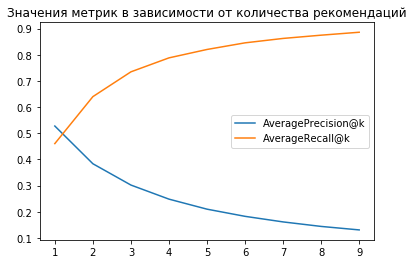

In [212]:
plt.plot(range(1, 10), precision_score, label = 'AveragePrecision@k')
plt.plot(range(1, 10), recall_score, label = 'AverageRecall@k')
plt.title('Значения метрик в зависимости от количества рекомендаций')
plt.legend()
plt.show()

# Вывод:

Для А/В теста рекомендуется использовать алгоритм формирования рекомендаций на основе частотности покупок с количеством рекомендаций, выбранных из соображений важности для бизнеса той или иной из рассчитанных метрик. 